# Convert measured ploughmeter voltage to load and azimuth

Particular for 2021: correct calibration and account for wire resistance (500m cable)

In [1]:
pwd

'/home/colili/Documents/PhD/ploughmeter_project/processing_2122'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
# nelder-mead optimization of noisy one-dimensional convex function
from scipy.optimize import minimize
from numpy.random import rand
from scipy import interpolate
import itertools
import time

In [2]:
# data=pd.read_table('raw_data/ploughemeter_data.dat', sep=',', skiprows=[0, 3], header=[0], parse_dates=[0])
data=pd.read_table('/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Data/ploughmeter/ploughmeter_data2122.dat', sep=',' 
                   ,skiprows=[0, 2, 3], header=[0], parse_dates=[0])

data

/home/colili/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


0          -0.343897
1          -0.341414
2           0.021915
3           0.021751
4           0.020986
             ...    
438548      Plough_X
438549          mV/V
438550           Smp
438551    0.01421821
438552    0.01422244
Name: Plough_X, Length: 438553, dtype: object

In [12]:
data

,TIMESTAMP,RECORD,batt_CR1000X,panel_tmpr_CR1000X,process_time,buff_depth,skipped_scans,CRDResult_Diagnostic,CRDResult_Data,Plough_V1,...,G4500SH_Noise,G4500SH_Decay,G4500SH_ohm,G4500SH_tmpr,G4500SH_Digits,G4500SH_Pressure,Relay_1_ForceOn,Relay_1_Powered,Relay_2_ForceOn,Relay_2_Powered
0,2021-05-01 02:01:00,310,13.07904,-8.482056,0,0,0,0,0,0.605606,...,2490.8,0.648438,9940.057,-0.303589,6065.038,2.728442,0,-1,0,-1
1,2021-05-01 02:02:00,311,13.07794,-8.505005,0,0,0,0,-1,0.602393,...,2490.8,0.648438,9940.027,-0.303528,6065.082,2.728386,0,-1,0,-1
2,2021-05-01 02:03:00,312,13.07686,-8.529694,0,0,0,0,0,785.6966,...,2490.9,0.648438,9940.044,-0.303558,6065.123,2.728333,0,-1,0,-1
3,2021-05-01 02:04:00,313,13.0759,-8.554016,0,0,0,0,0,785.6817,...,2490.8,0.640625,9940.07,-0.303589,6065.175,2.728267,0,-1,0,-1
4,2021-05-01 02:05:00,314,13.07311,-8.574951,0,0,0,0,0,785.6586,...,2490.8,0.640625,9940.031,-0.303558,6065.202,2.728233,0,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438548,TIMESTAMP,RECORD,batt_CR1000X,panel_tmpr_CR1000X,process_time,buff_depth,skipped_scans,CRDResult_Diagnostic,CRDResult_Data,Plough_V1,...,G4500SH_Noise,G4500SH_Decay,G4500SH_ohm,G4500SH_tmpr,G4500SH_Digits,G4500SH_Pressure,Relay_1_ForceOn,Relay_1_Powered,Relay_2_ForceOn,Relay_2_Powered
438549,TS,RN,V,°C,us,scans,scans,NaN,NaN,mV/V,...,hz,ratio,ohms,°C,unit,MPa,NaN,NaN,NaN,NaN
438550,NaN,NaN,Smp,Smp,Smp,Smp,Smp,Smp,Smp,Smp,...,Smp,Smp,Smp,Smp,Smp,Smp,Smp,Smp,Smp,Smp
438551,2022-04-28 09:29:00,0,0,-18.50098,0,0,0,0,0,785.9525,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1


In [4]:
data2=pd.read_table('/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Data/ploughmeter/allData2022_2.dat', sep=',' 
                   ,skiprows=[0, 2, 3], parse_dates=[0])
data2

/home/colili/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (12,49,50,51,52,53,54,55,56,57) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,2022-04-28 09:35:00,3,0,-18.76019,0.1,0.2,0.3,0.4,-1,785.9526,...,NAN.5,NAN.6,NAN.7,NAN.8,NAN.9,NAN.10,0.14,-1.1,0.15,-1.2
0,2022-04-28 09:41:00,6,0.00000,-18.728580,0,0,0,0,0,785.9502,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
1,2022-04-28 09:43:00,7,0.00000,-18.692730,0,0,0,0,0,785.9502,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
2,2022-04-28 09:45:00,8,0.00000,-18.758930,0,0,0,0,0,785.9497,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
3,2022-04-28 09:47:00,9,0.00000,-18.817760,0,0,0,0,0,785.9498,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
4,2022-04-28 09:51:00,10,0.00000,-18.732740,0,0,0,0,0,785.9472,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158604,2022-08-18 17:26:00,158640,14.01317,1.471527,0,0,0,0,0,783.2035,...,2451.5,0.632812,9962.974,-0.348633,5883.284,2.962091,0,-1,0,-1
158605,2022-08-18 17:27:00,158641,13.99842,1.459564,0,0,0,0,0,783.2086,...,2451.4,0.632812,9962.987,-0.348663,5883.246,2.962139,0,-1,0,-1
158606,2022-08-18 17:28:00,158642,14.00802,1.446838,0,0,0,0,0,783.2110,...,2451.4,0.632812,9962.982,-0.348663,5883.224,2.962168,0,-1,0,-1
158607,2022-08-18 17:29:00,158643,14.00459,1.433411,0,0,0,0,0,783.2136,...,2451.4,0.632812,9962.972,-0.348633,5883.192,2.962209,0,-1,0,-1


In [8]:
data2.columns = ['TIMESTAMP', 'RECORD', 'batt_CR1000X', 'panel_tmpr_CR1000X',
       'process_time', 'buff_depth', 'skipped_scans', 'CRDResult_Diagnostic',
       'CRDResult_Data', 'Plough_V1', 'Plough_X', 'Plough_Y',
       'GeoPrecision_tmpr(1)', 'GeoPrecision_tmpr(2)', 'GeoPrecision_tmpr(3)',
       'GeoPrecision_tmpr(4)', 'GeoPrecision_tmpr(5)', 'GeoPrecision_tmpr(6)',
       'GeoPrecision_tmpr(7)', 'GeoPrecision_tmpr(8)', 'GeoPrecision_tmpr(9)',
       'GeoPrecision_tmpr(10)', 'ThermStr_ratio(1)', 'ThermStr_ratio(2)',
       'ThermStr_ratio(3)', 'ThermStr_ratio(4)', 'ThermStr_ratio(5)',
       'ThermStr_ratio(6)', 'ThermStr_ratio(7)', 'ThermStr_ratio(8)',
       'ThermStr_ohm(1)', 'ThermStr_ohm(2)', 'ThermStr_ohm(3)',
       'ThermStr_ohm(4)', 'ThermStr_ohm(5)', 'ThermStr_ohm(6)',
       'ThermStr_ohm(7)', 'ThermStr_ohm(8)', 'ThermStr_tmpr(1)',
       'ThermStr_tmpr(2)', 'ThermStr_tmpr(3)', 'ThermStr_tmpr(4)',
       'ThermStr_tmpr(5)', 'ThermStr_tmpr(6)', 'ThermStr_tmpr(7)',
       'ThermStr_tmpr(8)', 'AVW200_result(1)', 'AVW200_result(2)',
       'batt_AVW200', 'G4500SH_Freq', 'G4500SH_Amp', 'G4500SH_SN',
       'G4500SH_Noise', 'G4500SH_Decay', 'G4500SH_ohm', 'G4500SH_tmpr',
       'G4500SH_Digits', 'G4500SH_Pressure', 'Relay_1_ForceOn',
       'Relay_1_Powered', 'Relay_2_ForceOn', 'Relay_2_Powered']

In [9]:
data2

,TIMESTAMP,RECORD,batt_CR1000X,panel_tmpr_CR1000X,process_time,buff_depth,skipped_scans,CRDResult_Diagnostic,CRDResult_Data,Plough_V1,...,G4500SH_Noise,G4500SH_Decay,G4500SH_ohm,G4500SH_tmpr,G4500SH_Digits,G4500SH_Pressure,Relay_1_ForceOn,Relay_1_Powered,Relay_2_ForceOn,Relay_2_Powered
0,2022-04-28 09:41:00,6,0.00000,-18.728580,0,0,0,0,0,785.9502,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
1,2022-04-28 09:43:00,7,0.00000,-18.692730,0,0,0,0,0,785.9502,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
2,2022-04-28 09:45:00,8,0.00000,-18.758930,0,0,0,0,0,785.9497,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
3,2022-04-28 09:47:00,9,0.00000,-18.817760,0,0,0,0,0,785.9498,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
4,2022-04-28 09:51:00,10,0.00000,-18.732740,0,0,0,0,0,785.9472,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158604,2022-08-18 17:26:00,158640,14.01317,1.471527,0,0,0,0,0,783.2035,...,2451.5,0.632812,9962.974,-0.348633,5883.284,2.962091,0,-1,0,-1
158605,2022-08-18 17:27:00,158641,13.99842,1.459564,0,0,0,0,0,783.2086,...,2451.4,0.632812,9962.987,-0.348663,5883.246,2.962139,0,-1,0,-1
158606,2022-08-18 17:28:00,158642,14.00802,1.446838,0,0,0,0,0,783.2110,...,2451.4,0.632812,9962.982,-0.348663,5883.224,2.962168,0,-1,0,-1
158607,2022-08-18 17:29:00,158643,14.00459,1.433411,0,0,0,0,0,783.2136,...,2451.4,0.632812,9962.972,-0.348633,5883.192,2.962209,0,-1,0,-1


In [5]:
data.drop(data.tail(43).index, inplace=True)

In [6]:
data.shape

(438510, 62)

In [7]:
# 438518:

In [8]:
data.columns

Index(['TIMESTAMP', 'RECORD', 'batt_CR1000X', 'panel_tmpr_CR1000X',
       'process_time', 'buff_depth', 'skipped_scans', 'CRDResult_Diagnostic',
       'CRDResult_Data', 'Plough_V1', 'Plough_X', 'Plough_Y',
       'GeoPrecision_tmpr(1)', 'GeoPrecision_tmpr(2)', 'GeoPrecision_tmpr(3)',
       'GeoPrecision_tmpr(4)', 'GeoPrecision_tmpr(5)', 'GeoPrecision_tmpr(6)',
       'GeoPrecision_tmpr(7)', 'GeoPrecision_tmpr(8)', 'GeoPrecision_tmpr(9)',
       'GeoPrecision_tmpr(10)', 'ThermStr_ratio(1)', 'ThermStr_ratio(2)',
       'ThermStr_ratio(3)', 'ThermStr_ratio(4)', 'ThermStr_ratio(5)',
       'ThermStr_ratio(6)', 'ThermStr_ratio(7)', 'ThermStr_ratio(8)',
       'ThermStr_ohm(1)', 'ThermStr_ohm(2)', 'ThermStr_ohm(3)',
       'ThermStr_ohm(4)', 'ThermStr_ohm(5)', 'ThermStr_ohm(6)',
       'ThermStr_ohm(7)', 'ThermStr_ohm(8)', 'ThermStr_tmpr(1)',
       'ThermStr_tmpr(2)', 'ThermStr_tmpr(3)', 'ThermStr_tmpr(4)',
       'ThermStr_tmpr(5)', 'ThermStr_tmpr(6)', 'ThermStr_tmpr(7)',
       'ThermS

In [9]:
data.drop(columns=['RECORD', 'batt_CR1000X', 'panel_tmpr_CR1000X', 'process_time',
       'buff_depth', 'skipped_scans', 'CRDResult_Diagnostic', 'CRDResult_Data',
       'GeoPrecision_tmpr(1)',
       'GeoPrecision_tmpr(2)', 'GeoPrecision_tmpr(3)', 'GeoPrecision_tmpr(4)',
       'GeoPrecision_tmpr(5)', 'GeoPrecision_tmpr(6)', 'GeoPrecision_tmpr(7)',
       'GeoPrecision_tmpr(8)', 'GeoPrecision_tmpr(9)', 'GeoPrecision_tmpr(10)',
       'ThermStr_ratio(1)', 'ThermStr_ratio(2)', 'ThermStr_ratio(3)',
       'ThermStr_ratio(4)', 'ThermStr_ratio(5)', 'ThermStr_ratio(6)',
       'ThermStr_ratio(7)', 'ThermStr_ratio(8)', 'ThermStr_ohm(1)',
       'ThermStr_ohm(2)', 'ThermStr_ohm(3)', 'ThermStr_ohm(4)',
       'ThermStr_ohm(5)', 'ThermStr_ohm(6)', 'ThermStr_ohm(7)',
       'ThermStr_ohm(8)', 'ThermStr_tmpr(1)', 'ThermStr_tmpr(2)',
       'ThermStr_tmpr(3)', 'ThermStr_tmpr(4)', 'ThermStr_tmpr(5)',
       'ThermStr_tmpr(6)', 'ThermStr_tmpr(7)', 'ThermStr_tmpr(8)',
       'AVW200_result(1)', 'AVW200_result(2)', 'batt_AVW200', 'G4500SH_Freq',
       'G4500SH_Amp', 'G4500SH_SN', 'G4500SH_Noise', 'G4500SH_Decay',
       'G4500SH_ohm', 'G4500SH_tmpr', 'G4500SH_Digits',
       'Relay_1_ForceOn', 'Relay_1_Powered', 'Relay_2_ForceOn',
       'Relay_2_Powered'], inplace=True)

In [10]:
data2.drop(columns=['RECORD', 'batt_CR1000X', 'panel_tmpr_CR1000X', 'process_time',
       'buff_depth', 'skipped_scans', 'CRDResult_Diagnostic', 'CRDResult_Data',
       'GeoPrecision_tmpr(1)',
       'GeoPrecision_tmpr(2)', 'GeoPrecision_tmpr(3)', 'GeoPrecision_tmpr(4)',
       'GeoPrecision_tmpr(5)', 'GeoPrecision_tmpr(6)', 'GeoPrecision_tmpr(7)',
       'GeoPrecision_tmpr(8)', 'GeoPrecision_tmpr(9)', 'GeoPrecision_tmpr(10)',
       'ThermStr_ratio(1)', 'ThermStr_ratio(2)', 'ThermStr_ratio(3)',
       'ThermStr_ratio(4)', 'ThermStr_ratio(5)', 'ThermStr_ratio(6)',
       'ThermStr_ratio(7)', 'ThermStr_ratio(8)', 'ThermStr_ohm(1)',
       'ThermStr_ohm(2)', 'ThermStr_ohm(3)', 'ThermStr_ohm(4)',
       'ThermStr_ohm(5)', 'ThermStr_ohm(6)', 'ThermStr_ohm(7)',
       'ThermStr_ohm(8)', 'ThermStr_tmpr(1)', 'ThermStr_tmpr(2)',
       'ThermStr_tmpr(3)', 'ThermStr_tmpr(4)', 'ThermStr_tmpr(5)',
       'ThermStr_tmpr(6)', 'ThermStr_tmpr(7)', 'ThermStr_tmpr(8)',
       'AVW200_result(1)', 'AVW200_result(2)', 'batt_AVW200', 'G4500SH_Freq',
       'G4500SH_Amp', 'G4500SH_SN', 'G4500SH_Noise', 'G4500SH_Decay',
       'G4500SH_ohm', 'G4500SH_tmpr', 'G4500SH_Digits',
       'Relay_1_ForceOn', 'Relay_1_Powered', 'Relay_2_ForceOn',
       'Relay_2_Powered'], inplace=True)

In [10]:
data

,TIMESTAMP,Plough_V1,Plough_X,Plough_Y,G4500SH_Pressure
0,2021-05-01 02:01:00,0.605606,-0.343897,NaN,2.728442
1,2021-05-01 02:02:00,0.602393,-0.341414,NaN,2.728386
2,2021-05-01 02:03:00,785.6966,0.021915,0.017336,2.728333
3,2021-05-01 02:04:00,785.6817,0.021751,0.017878,2.728267
4,2021-05-01 02:05:00,785.6586,0.020986,0.018225,2.728233
...,...,...,...,...,...
438505,2022-02-15 20:46:00,785.7082,0.01390612,0.03268845,NAN
438506,2022-02-15 20:48:00,785.7285,0.01397294,0.03269318,2.938235
438507,2022-02-15 20:49:00,785.7339,0.01396865,0.03268151,NAN
438508,2022-02-15 20:51:00,785.7517,0.01403672,0.03268965,NAN


In [11]:
data2

,TIMESTAMP,Plough_V1,Plough_X,Plough_Y,G4500SH_Pressure
0,2022-04-28 09:41:00,785.9502,0.014231,0.036010,NAN
1,2022-04-28 09:43:00,785.9502,0.014215,0.036015,NAN
2,2022-04-28 09:45:00,785.9497,0.014231,0.036011,NAN
3,2022-04-28 09:47:00,785.9498,0.014218,0.036008,NAN
4,2022-04-28 09:51:00,785.9472,0.014222,0.036017,NAN
...,...,...,...,...,...
158604,2022-08-18 17:26:00,783.2035,-0.089512,0.025825,2.962091
158605,2022-08-18 17:27:00,783.2086,-0.089506,0.025846,2.962139
158606,2022-08-18 17:28:00,783.2110,-0.089478,0.025825,2.962168
158607,2022-08-18 17:29:00,783.2136,-0.089493,0.025820,2.962209


In [11]:
data[147455:]

,TIMESTAMP,Plough_V1,Plough_X,Plough_Y,G4500SH_Pressure
147455,2021-08-15 16:33:00,783.2497,0.013188,0.022021,2.491982
147456,2021-08-15 16:34:00,783.2511,0.01318836,0.02203325,2.492095
147457,2021-08-15 16:35:00,783.2526,0.01319391,0.02203715,2.492207
147458,2021-08-15 16:36:00,783.2526,0.01320267,0.02201631,2.492314
147459,2021-08-15 16:37:00,783.2529,0.01318556,0.02201915,2.492422
...,...,...,...,...,...
438505,2022-02-15 20:46:00,785.7082,0.01390612,0.03268845,NAN
438506,2022-02-15 20:48:00,785.7285,0.01397294,0.03269318,2.938235
438507,2022-02-15 20:49:00,785.7339,0.01396865,0.03268151,NAN
438508,2022-02-15 20:51:00,785.7517,0.01403672,0.03268965,NAN


In [14]:
i=data[data['Plough_X'].str.contains('Plough_X')==True].index
#i2=data2[data2['Plough_X'].str.contains('Plough_X')==True].index

In [15]:
j=data[data['Plough_X'].str.contains('mV/V')==True].index
j

Int64Index([154198, 154237, 154270, 154303, 154336, 154369, 154402, 154435,
            154468, 154501,
            ...
            438301, 438334, 438367, 438400, 438433, 438462, 438490, 438515,
            438533, 438549],
           dtype='int64', length=8619)

In [16]:
k=data[data['Plough_X'].str.contains('Smp')==True].index
k

Int64Index([154199, 154238, 154271, 154304, 154337, 154370, 154403, 154436,
            154469, 154502,
            ...
            438302, 438335, 438368, 438401, 438434, 438463, 438491, 438516,
            438534, 438550],
           dtype='int64', length=8619)

In [17]:
data_clean=data.drop(data.index[i])

In [18]:
data_clean=data_clean.drop(data.index[j])

In [19]:
data_clean=data_clean.drop(data.index[k])

In [20]:
data_clean

,TIMESTAMP,RECORD,batt_CR1000X,panel_tmpr_CR1000X,process_time,buff_depth,skipped_scans,CRDResult_Diagnostic,CRDResult_Data,Plough_V1,...,G4500SH_Noise,G4500SH_Decay,G4500SH_ohm,G4500SH_tmpr,G4500SH_Digits,G4500SH_Pressure,Relay_1_ForceOn,Relay_1_Powered,Relay_2_ForceOn,Relay_2_Powered
0,2021-05-01 02:01:00,310,13.07904,-8.482056,0,0,0,0,0,0.605606,...,2490.8,0.648438,9940.057,-0.303589,6065.038,2.728442,0,-1,0,-1
1,2021-05-01 02:02:00,311,13.07794,-8.505005,0,0,0,0,-1,0.602393,...,2490.8,0.648438,9940.027,-0.303528,6065.082,2.728386,0,-1,0,-1
2,2021-05-01 02:03:00,312,13.07686,-8.529694,0,0,0,0,0,785.6966,...,2490.9,0.648438,9940.044,-0.303558,6065.123,2.728333,0,-1,0,-1
3,2021-05-01 02:04:00,313,13.0759,-8.554016,0,0,0,0,0,785.6817,...,2490.8,0.640625,9940.07,-0.303589,6065.175,2.728267,0,-1,0,-1
4,2021-05-01 02:05:00,314,13.07311,-8.574951,0,0,0,0,0,785.6586,...,2490.8,0.640625,9940.031,-0.303558,6065.202,2.728233,0,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438545,2022-02-15 21:56:00,413001,8.26475,-18.39655,0,0,0,0,0,785.9689,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
438546,2022-02-15 21:58:00,413002,8.280935,-18.452,0,0,0,0,0,785.9802,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
438547,2022-02-15 22:00:00,413003,8.260977,-18.50233,0,0,0,0,0,785.9898,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1
438551,2022-04-28 09:29:00,0,0,-18.50098,0,0,0,0,0,785.9525,...,NAN,NAN,NAN,NAN,NAN,NAN,0,-1,0,-1


In [21]:
data_clean.set_index('TIMESTAMP', inplace=True)

In [24]:
data2.set_index('TIMESTAMP', inplace=True)

In [25]:
data_clean.index=pd.to_datetime(data_clean.index)
data2.index=pd.to_datetime(data2.index)

In [32]:
data2

,Plough_V1,Plough_X,Plough_Y,G4500SH_Pressure
TIMESTAMP,,,,
2022-04-28 09:41:00,785.9502,0.014231,0.036010,NAN
2022-04-28 09:43:00,785.9502,0.014215,0.036015,NAN
2022-04-28 09:45:00,785.9497,0.014231,0.036011,NAN
2022-04-28 09:47:00,785.9498,0.014218,0.036008,NAN
2022-04-28 09:51:00,785.9472,0.014222,0.036017,NAN
...,...,...,...,...
2022-08-18 17:26:00,783.2035,-0.089512,0.025825,2.962091
2022-08-18 17:27:00,783.2086,-0.089506,0.025846,2.962139
2022-08-18 17:28:00,783.2110,-0.089478,0.025825,2.962168


In [27]:
data_clean['Plough_V1']=data_clean['Plough_V1'].apply(pd.to_numeric, errors='coerce')
data_clean['Plough_X']=data_clean['Plough_X'].apply(pd.to_numeric, errors='coerce')
data_clean['Plough_Y']=data_clean['Plough_Y'].apply(pd.to_numeric, errors='coerce')
data_clean['G4500SH_Pressure']=data_clean['G4500SH_Pressure'].apply(pd.to_numeric, errors='coerce')

In [35]:
data2['G4500SH_Pressure']=data2['G4500SH_Pressure'].apply(pd.to_numeric, errors='coerce')

In [36]:
data_10min = data_clean.resample('10Min').mean()
data2_10min = data2.resample('10Min').mean()
data2_10min

,Plough_V1,Plough_X,Plough_Y,G4500SH_Pressure
TIMESTAMP,,,,
2022-04-28 09:40:00,785.949975,0.014224,0.036011,NaN
2022-04-28 09:50:00,785.947620,0.014222,0.036020,NaN
2022-04-28 10:00:00,NaN,NaN,NaN,NaN
2022-04-28 10:10:00,NaN,NaN,NaN,NaN
2022-04-28 10:20:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-08-18 16:50:00,783.161150,-0.089618,0.025822,2.960870
2022-08-18 17:00:00,783.162290,-0.089614,0.025818,2.961262
2022-08-18 17:10:00,783.179090,-0.089579,0.025826,2.961649


In [24]:
data_10min.columns

Index(['Plough_V1', 'Plough_X', 'Plough_Y', 'G4500SH_Pressure'], dtype='object')

## Taking the excitation voltage

In [37]:
Vex = 4 # [V]

In [38]:
Plough_offset_X = 0.757 #Zero offset from calibration
Plough_offset_Y = 0.004 #Zero offset from calibration

In [40]:
data2_10min['Plough_X']

TIMESTAMP
2022-04-28 09:40:00    0.014224
2022-04-28 09:50:00    0.014222
2022-04-28 10:00:00         NaN
2022-04-28 10:10:00         NaN
2022-04-28 10:20:00         NaN
                         ...   
2022-08-18 16:50:00   -0.089618
2022-08-18 17:00:00   -0.089614
2022-08-18 17:10:00   -0.089579
2022-08-18 17:20:00   -0.089514
2022-08-18 17:30:00   -0.089493
Freq: 10T, Name: Plough_X, Length: 16176, dtype: float64

In [43]:
result = pd.concat([data_10min, data2_10min])

In [42]:
df_plough

,Plough_V1,Plough_X,Plough_Y,G4500SH_Pressure
TIMESTAMP,,,,
2021-05-01 02:00:00,611.191544,-0.059707,0.018255,2.728246
2021-05-01 02:10:00,785.556190,0.020834,0.019473,2.727926
2021-05-01 02:20:00,785.539760,0.021035,0.020254,2.727686
2021-05-01 02:30:00,785.537350,0.020965,0.020960,2.727484
2021-05-01 02:40:00,785.524380,0.018875,0.020759,2.727291
...,...,...,...,...
2022-08-18 16:50:00,783.161150,-0.089618,0.025822,2.960870
2022-08-18 17:00:00,783.162290,-0.089614,0.025818,2.961262
2022-08-18 17:10:00,783.179090,-0.089579,0.025826,2.961649


In [44]:
df_plough = pd.DataFrame()

In [29]:
data_10min.columns

Index(['Plough_V1', 'Plough_X', 'Plough_Y', 'G4500SH_Pressure'], dtype='object')

In [45]:
df_plough['X'] = (result['Plough_X']+Plough_offset_X)*Vex
df_plough['Y'] = (result['Plough_Y']+Plough_offset_Y)*Vex

In [46]:
df_plough.set_index(result.index)

,X,Y
TIMESTAMP,,
2021-05-01 02:00:00,2.789172,0.089020
2021-05-01 02:10:00,3.111336,0.093893
2021-05-01 02:20:00,3.112140,0.097017
2021-05-01 02:30:00,3.111859,0.099839
2021-05-01 02:40:00,3.103500,0.099036
...,...,...
2022-08-18 16:50:00,2.669530,0.119287
2022-08-18 17:00:00,2.669543,0.119272
2022-08-18 17:10:00,2.669682,0.119303


In [32]:
#df_plough['V1']=data_10min['Plough_V1']

In [47]:
df_plough['V1V'] = result['Plough_V1']*Vex/1e3

In [48]:
df_plough['V1'] = df_plough['V1V']/(1+((Vex-df_plough['V1V'])/(2*df_plough['V1V']-Vex)))

In [49]:
df_plough

,X,Y,V1V,V1
TIMESTAMP,,,,
2021-05-01 02:00:00,2.789172,0.089020,2.444766,0.889532
2021-05-01 02:10:00,3.111336,0.093893,3.142225,2.284450
2021-05-01 02:20:00,3.112140,0.097017,3.142159,2.284318
2021-05-01 02:30:00,3.111859,0.099839,3.142149,2.284299
2021-05-01 02:40:00,3.103500,0.099036,3.142098,2.284195
...,...,...,...,...
2022-08-18 16:50:00,2.669530,0.119287,3.132645,2.265289
2022-08-18 17:00:00,2.669543,0.119272,3.132649,2.265298
2022-08-18 17:10:00,2.669682,0.119303,3.132716,2.265433


In [50]:
df_plough['X']=df_plough['X']/df_plough['V1']
df_plough['Y']=df_plough['Y']/df_plough['V1']

In [51]:
df_plough

,X,Y,V1V,V1
TIMESTAMP,,,,
2021-05-01 02:00:00,3.135549,0.100075,2.444766,0.889532
2021-05-01 02:10:00,1.361963,0.041101,3.142225,2.284450
2021-05-01 02:20:00,1.362394,0.042471,3.142159,2.284318
2021-05-01 02:30:00,1.362282,0.043707,3.142149,2.284299
2021-05-01 02:40:00,1.358684,0.043357,3.142098,2.284195
...,...,...,...,...
2022-08-18 16:50:00,1.178450,0.052659,3.132645,2.265289
2022-08-18 17:00:00,1.178451,0.052652,3.132649,2.265298
2022-08-18 17:10:00,1.178443,0.052662,3.132716,2.265433


## Load the calibration data

In [52]:
data_calib = pd.read_excel('/home/colili/Documents/PhD/ploughmeter_project/Data/raw_data/Calibration_Ploughmeter.xlsx')
data_calib

,deg,orient,X-10kg,Y-10kg,X-50kg,Y-50kg
0,0,X+,0.024061,0.000189,0.115814,-0.000063
1,45,X+,0.015952,0.016106,0.079813,0.076296
2,90,Y+,-0.000067,0.022718,-0.000056,0.110277
3,135,Y+,-0.015721,0.017472,-0.076557,0.083677
4,180,X-,-0.022823,-0.000146,-0.111042,0.000087
5,225,X-,-0.014949,-0.016362,-0.079370,-0.076103
6,270,Y-,-0.000036,-0.023444,0.000009,-0.112989
7,315,Y-,0.018523,-0.017728,0.083647,-0.090655


In [53]:
df_X10=pd.DataFrame({'X':data_calib['X-10kg'].iloc[lambda x: x.index % 2 == 0]})
df_X50=pd.DataFrame({'X':data_calib['X-50kg'].iloc[lambda x: x.index % 2 == 0]})
df_X=pd.concat([df_X10, df_X50])
df_Xloads=pd.DataFrame({'Load':[10,0,-10,0,50,0,-50, 0]})
df_X

,X
0,0.024061
2,-0.000067
4,-0.022823
6,-0.000036
0,0.115814
2,-0.000056
4,-0.111042
6,0.000009


In [54]:
df_Y10=pd.DataFrame({'Y':data_calib['Y-10kg'].iloc[lambda x: x.index % 2 == 0]})
df_Y50=pd.DataFrame({'Y':data_calib['Y-50kg'].iloc[lambda x: x.index % 2 == 0]})
df_Y=pd.concat([df_Y10, df_Y50])
df_Yloads=pd.DataFrame({'Load':[0,10,0,-10,0,50,0,-50]})
df_Y

,Y
0,0.000189
2,0.022718
4,-0.000146
6,-0.023444
0,-0.000063
2,0.110277
4,0.000087
6,-0.112989


In [55]:
Vex = 2.5 # excitation voltage in [V] for CR6 but Vex = 4 for CR1000X...
Xoff = 0.757 # Zero offset from calibration
Yoff = 0.004 # Zero offset from calibration
V1 = 1362.4 # effective Vex at the bridge in [mV]

In [56]:
corr = Vex/(V1/1e3)

In [57]:
df_X['X'] = (df_X['X']+Xoff)*corr
df_Y['Y'] = (df_Y['Y']+Yoff)*corr

In [58]:
df_Y['Y']

0    0.007687
2    0.049028
4    0.007071
6   -0.035679
0    0.007224
2    0.209698
4    0.007499
6   -0.199994
Name: Y, dtype: float64

In [59]:
x=[-50, 50]
px=np.polyfit(df_X['X'], df_Xloads['Load'], 1)
py=np.polyfit(df_Y['Y'], df_Yloads['Load'], 1)

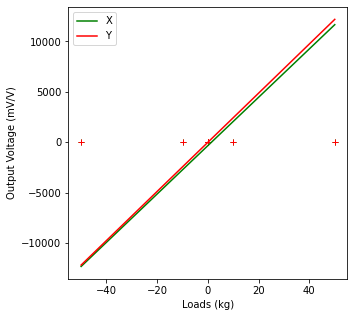

In [60]:
fig, ax = plt.subplots(figsize=(5,5))
x=np.arange(-50, 51)
ax.plot(df_Xloads['Load'], df_X, 'g+')
ax.plot(df_Yloads['Load'], df_Y, 'r+')
ax.plot(x, np.polyval(px, x), 'g', label='X')
ax.plot(x, np.polyval(py, x), 'r', label='Y')
ax.set_xlabel('Loads (kg)')
ax.set_ylabel('Output Voltage (mV/V)')
plt.legend()

In [61]:
px

array([ 239.83543659, -333.47601866])

In [62]:
Cx = [px[0], 0, px[1]]
Cy=[py[0], 90, py[1]]
print(Cx, Cy)

[239.83543659256642, 0, -333.4760186574914] [243.73407473683312, 90, -1.6005220474411075]


In [63]:
max(np.polyval(py, x))-max(np.polyval(px, x))

526.8074038233844

## Deriving Lx and Ly based on the calibration data

In [64]:
df_plough

,X,Y,V1V,V1
TIMESTAMP,,,,
2021-05-01 02:00:00,3.135549,0.100075,2.444766,0.889532
2021-05-01 02:10:00,1.361963,0.041101,3.142225,2.284450
2021-05-01 02:20:00,1.362394,0.042471,3.142159,2.284318
2021-05-01 02:30:00,1.362282,0.043707,3.142149,2.284299
2021-05-01 02:40:00,1.358684,0.043357,3.142098,2.284195
...,...,...,...,...
2022-08-18 16:50:00,1.178450,0.052659,3.132645,2.265289
2022-08-18 17:00:00,1.178451,0.052652,3.132649,2.265298
2022-08-18 17:10:00,1.178443,0.052662,3.132716,2.265433


In [65]:
df_plough['Lx'] = df_plough['X']*Cx[0]+Cx[2]
df_plough['Ly'] = df_plough['Y']*Cy[0]+Cy[2]

In [66]:
df_plough['X']

TIMESTAMP
2021-05-01 02:00:00    3.135549
2021-05-01 02:10:00    1.361963
2021-05-01 02:20:00    1.362394
2021-05-01 02:30:00    1.362282
2021-05-01 02:40:00    1.358684
                         ...   
2022-08-18 16:50:00    1.178450
2022-08-18 17:00:00    1.178451
2022-08-18 17:10:00    1.178443
2022-08-18 17:20:00    1.178463
2022-08-18 17:30:00    1.178437
Freq: 10T, Name: X, Length: 68350, dtype: float64

In [67]:
df_plough['L'] = np.sqrt(df_plough['Lx']**2+df_plough['Ly']**2)

In [68]:
df_plough['Theta'] = (np.arctan2(df_plough['Ly'], df_plough['Lx']))*180/np.pi
df_plough['Theta']

TIMESTAMP
2021-05-01 02:00:00      3.116912
2021-05-01 02:10:00    129.053174
2021-05-01 02:20:00    127.544682
2021-05-01 02:30:00    126.721059
2021-05-01 02:40:00    130.339976
                          ...    
2022-08-18 16:50:00    167.540013
2022-08-18 17:00:00    167.541729
2022-08-18 17:10:00    167.539422
2022-08-18 17:20:00    167.537899
2022-08-18 17:30:00    167.540460
Freq: 10T, Name: Theta, Length: 68350, dtype: float64

In [69]:
df_plough

,X,Y,V1V,V1,Lx,Ly,L,Theta
TIMESTAMP,,,,,,,,
2021-05-01 02:00:00,3.135549,0.100075,2.444766,0.889532,418.539750,22.791210,419.159828,3.116912
2021-05-01 02:10:00,1.361963,0.041101,3.142225,2.284450,-6.829026,8.417161,10.839013,129.053174
2021-05-01 02:20:00,1.362394,0.042471,3.142159,2.284318,-6.725778,8.751065,11.037084,127.544682
2021-05-01 02:30:00,1.362282,0.043707,3.142149,2.284299,-6.752561,9.052310,11.293423,126.721059
2021-05-01 02:40:00,1.358684,0.043357,3.142098,2.284195,-7.615386,8.967064,11.764453,130.339976
...,...,...,...,...,...,...,...,...
2022-08-18 16:50:00,1.178450,0.052659,3.132645,2.265289,-50.841983,11.234151,52.068353,167.540013
2022-08-18 17:00:00,1.178451,0.052652,3.132649,2.265298,-50.841763,11.232505,52.067784,167.541729
2022-08-18 17:10:00,1.178443,0.052662,3.132716,2.265433,-50.843747,11.235091,52.070278,167.539422


In [70]:
df_plough.index[996:]

DatetimeIndex(['2021-05-08 00:00:00', '2021-05-08 00:10:00',
               '2021-05-08 00:20:00', '2021-05-08 00:30:00',
               '2021-05-08 00:40:00', '2021-05-08 00:50:00',
               '2021-05-08 01:00:00', '2021-05-08 01:10:00',
               '2021-05-08 01:20:00', '2021-05-08 01:30:00',
               ...
               '2022-08-18 16:00:00', '2022-08-18 16:10:00',
               '2022-08-18 16:20:00', '2022-08-18 16:30:00',
               '2022-08-18 16:40:00', '2022-08-18 16:50:00',
               '2022-08-18 17:00:00', '2022-08-18 17:10:00',
               '2022-08-18 17:20:00', '2022-08-18 17:30:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=67354, freq='10T')

In [74]:
result

,Plough_V1,Plough_X,Plough_Y,G4500SH_Pressure
TIMESTAMP,,,,
2021-05-01 02:00:00,611.191544,-0.059707,0.018255,2.728246
2021-05-01 02:10:00,785.556190,0.020834,0.019473,2.727926
2021-05-01 02:20:00,785.539760,0.021035,0.020254,2.727686
2021-05-01 02:30:00,785.537350,0.020965,0.020960,2.727484
2021-05-01 02:40:00,785.524380,0.018875,0.020759,2.727291
...,...,...,...,...
2022-08-18 16:50:00,783.161150,-0.089618,0.025822,2.960870
2022-08-18 17:00:00,783.162290,-0.089614,0.025818,2.961262
2022-08-18 17:10:00,783.179090,-0.089579,0.025826,2.961649


In [75]:
df_plough['Pe'] = result['G4500SH_Pressure'][996:]

## Ignore everything which is before the 9th of May

In [76]:
df_plough.drop(df_plough.index[0:1140], inplace=True)
df_plough.to_csv('/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Data/ploughmeter/df_LTheta.csv')

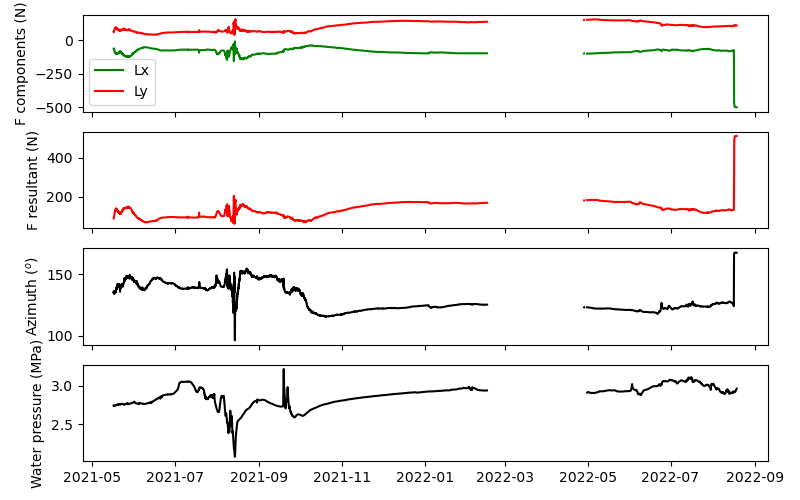

In [77]:
%matplotlib widget
g = 9.8
fig, axs = plt.subplots(4, 1, figsize=(8,5), sharex = True)
axs[0].plot(df_plough.index, df_plough['Lx']*g, label='Lx', color='g')
axs[0].plot(df_plough.index, df_plough['Ly']*g, label='Ly', color='r')
axs[0].set_ylabel('F components (N)')
axs[0].legend()

axs[1].plot(df_plough.index, df_plough['L']*g, color='r')
axs[1].set_ylabel('F resultant (N)')

axs[2].plot(df_plough.index, df_plough['Theta'], color='k')
axs[2].set_ylabel('Azimuth ($^o$)')

axs[3].plot(df_plough.index, df_plough['Pe'], color='k')
axs[3].set_ylabel('Water pressure (MPa)')

plt.tight_layout()
plt.savefig('/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Figure/raw_data_2122.pdf', bbox_inches='tight')